In [1]:
install.packages("igraph")
install.packages("pracma")
install.packages('resample')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library('igraph')
library('Matrix')
library('pracma')
library('resample')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu




In [3]:
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}

random_walk = function (g, num_steps, start_node, transition_matrix = NULL, mode, tp=0.15, pr, medians){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    for(i in 1:num_steps){
        #fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        PMF = transition_matrix[v, ]

        if (mode == "base")
          v = sample(1:vcount(g), 1, prob = PMF)

        else{
          rn = runif(n=1, min=0, max=1) # generate a randome number from 0 -> 1 w/ uniform dist.
          if (rn < tp) {
            if (mode == "teleport")
              v = sample(1:vcount(g), 1)
            else if (mode == "pagerank")
              v = sample(1:vcount(g), 1, prob=pr)
            else if (mode == "prmedian")
              v = sample(medians, 1)
            else
              print("Invalid mode!")
              quit()
          }
          else
            v = sample(1:vcount(g), 1, prob=PMF)
        }
    }
    
    return(v)
}

eval_page_rank = function (g, num_steps, mode, tp=0.15, pr, medians,num_iters){
  # Initialize vector that counts visited node
  visitedCount <- rep(0, vcount(g))

  for (i in 1:num_iters){
    start_node <- sample(1:vcount(combined_graph), 1)
    visited_nodes <- random_walk(g, num_steps, start_node, transition_matrix = NULL, mode, tp=0.15, pr, medians)
    j <- length(visited_nodes)
    visitedCount[visited_nodes[j]] = visitedCount[visited_nodes[j]] + 1  
  }
  nodeProb <- visitedCount / sum(visitedCount)
  return (nodeProb)
}

# 2. Random Walk on Networks

### 3. PageRank

#### (a) Base (no teleportation)

In [4]:
# (a) Directed random network with 1000 nodes
# using the preferential attachment model

N <- 1000
M <- 4

g1 <- barabasi.game(n=N, m=M, directed=TRUE)

# create another random network
g2_0 <- barabasi.game(n=N, m=M, directed=TRUE)

# shuffle network 2 and combine to prevent a 'black hole' when doing random walk
g2_permute <- permute(g2_0, sample(vcount(g2_0)))
g2_edges <- t(as_edgelist(g2_permute))
combined_graph <- add_edges(g1, c(g2_edges))

In [5]:
num_steps <- 500
num_iters <- 100
mode_3a <- "base"

pagerank_base <- eval_page_rank(g=combined_graph,
                                    num_iters=num_iters,
                                    num_steps=num_steps,
                                    mode=mode_3a)

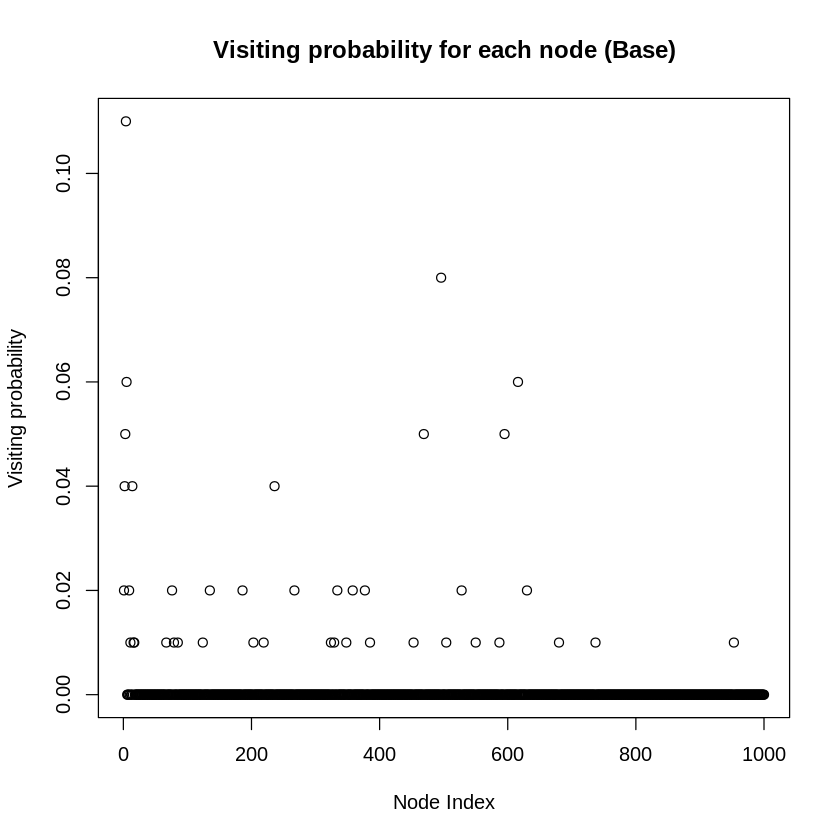

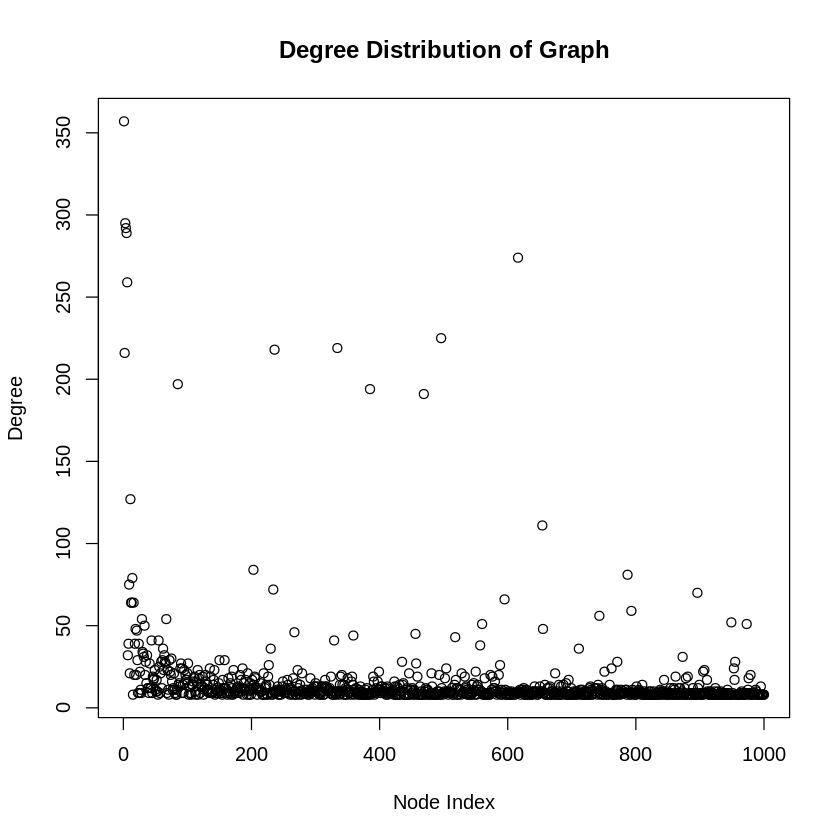

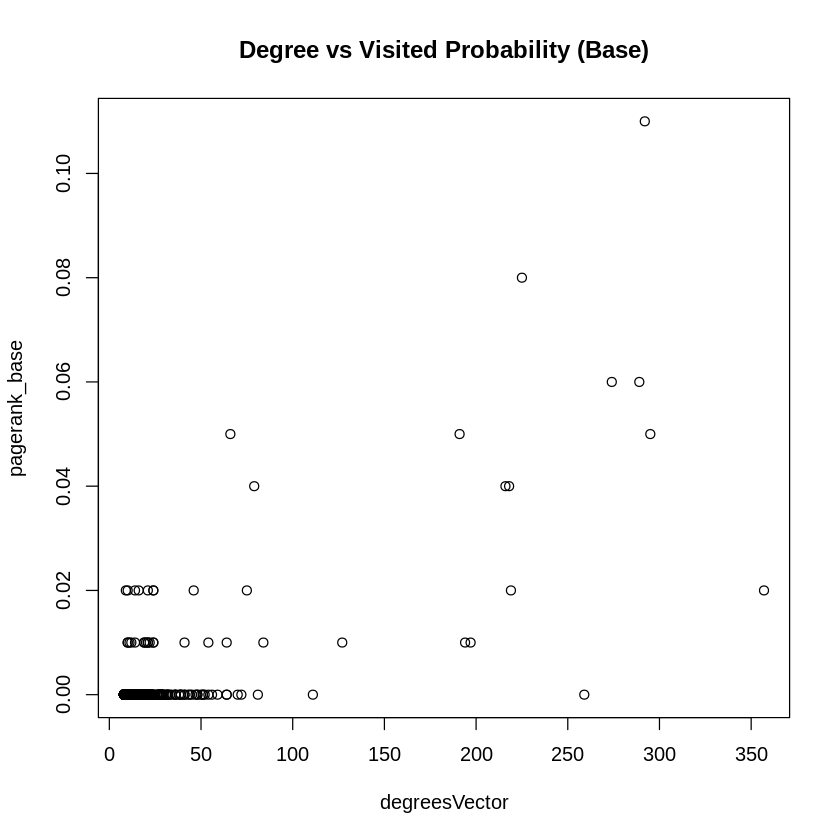

In [6]:
plot(pagerank_base, xlab="Node Index", ylab="Visiting probability", main= "Visiting probability for each node (Base)")

degreesVector <- degree(combined_graph, mode="all")
plot(degreesVector, xlab="Node Index", ylab="Degree", main = "Degree Distribution of Graph")

plot(degreesVector, pagerank_base, main = "Degree vs Visited Probability (Base)")

In [7]:
print(cor(degreesVector, pagerank_base))

[1] 0.7407246


#### (b) Teleportation probability with $\alpha = 0.15$

In [8]:
num_steps <- 500
num_iters <- 100
alpha <- 0.15
mode_3b <- "teleport"

pagerank_teleport <- eval_page_rank(g=combined_graph,
                                    num_iters=num_iters,
                                    num_steps=num_steps,
                                    tp=alpha,
                                    mode=mode_3b)

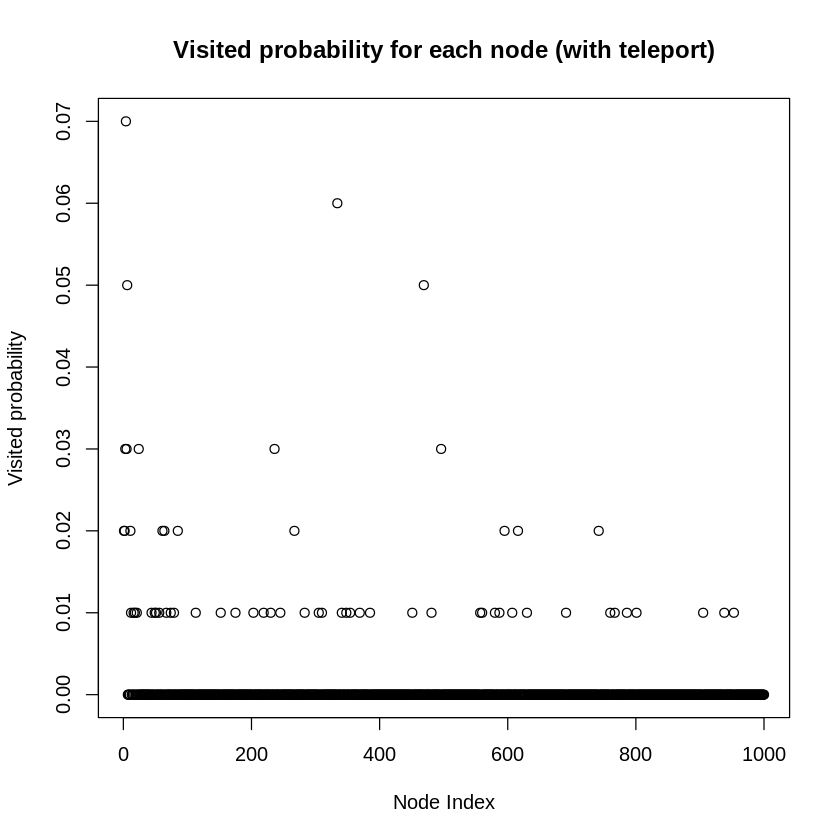

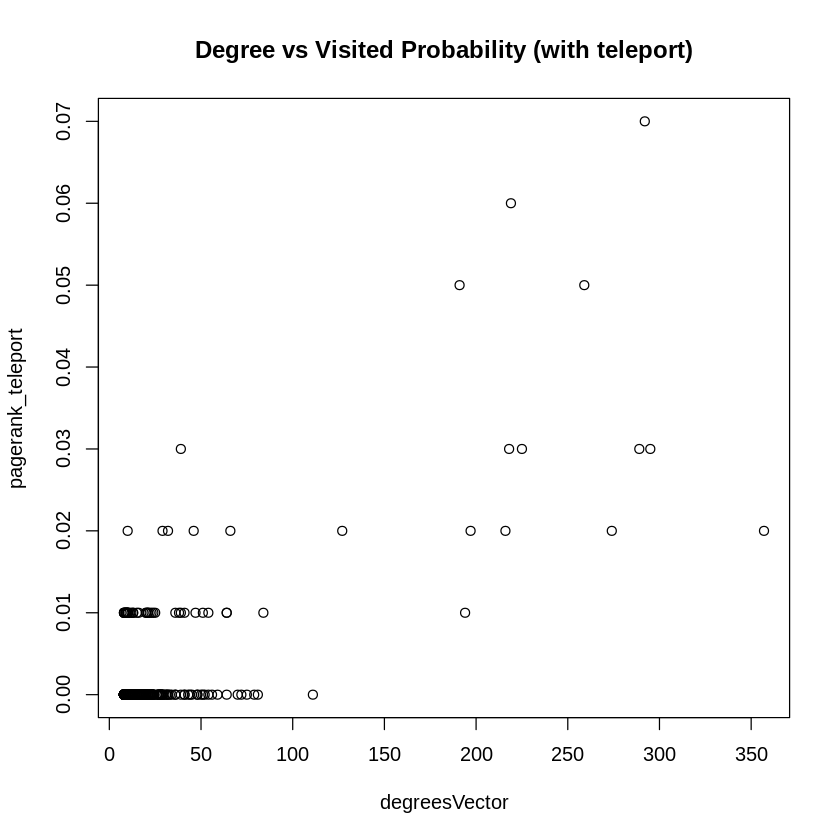

In [9]:
plot(pagerank_teleport, xlab="Node Index", ylab="Visited probability", main= "Visited probability for each node (with teleport)")

plot(degreesVector, pagerank_teleport, main = "Degree vs Visited Probability (with teleport)")

In [10]:
print(cor(degreesVector, pagerank_teleport))

[1] 0.7553701


### 4. Personalized PageRank

#### (a) Teleportation probability is proportional to PageRank

In [11]:
num_steps <- 500
num_iters <- 100
mode_4a <- "pagerank"

pr_4a <- eval_page_rank(g=combined_graph,
                                    mode=mode_4a,
                                    num_iters=num_iters,
                                    num_steps=num_steps,
                                    pr=pagerank_base)

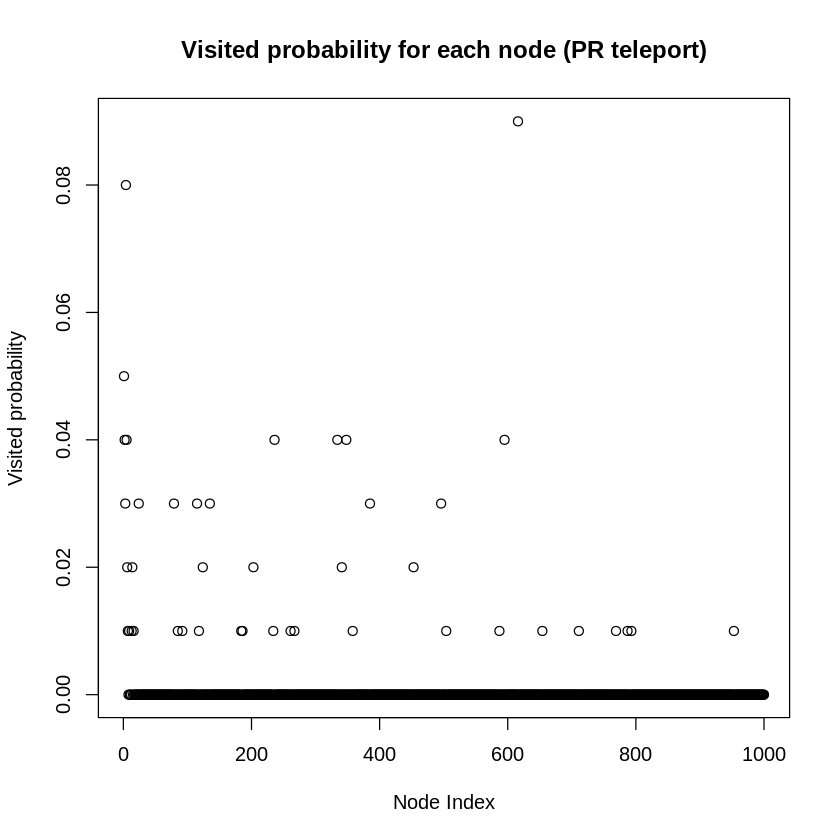

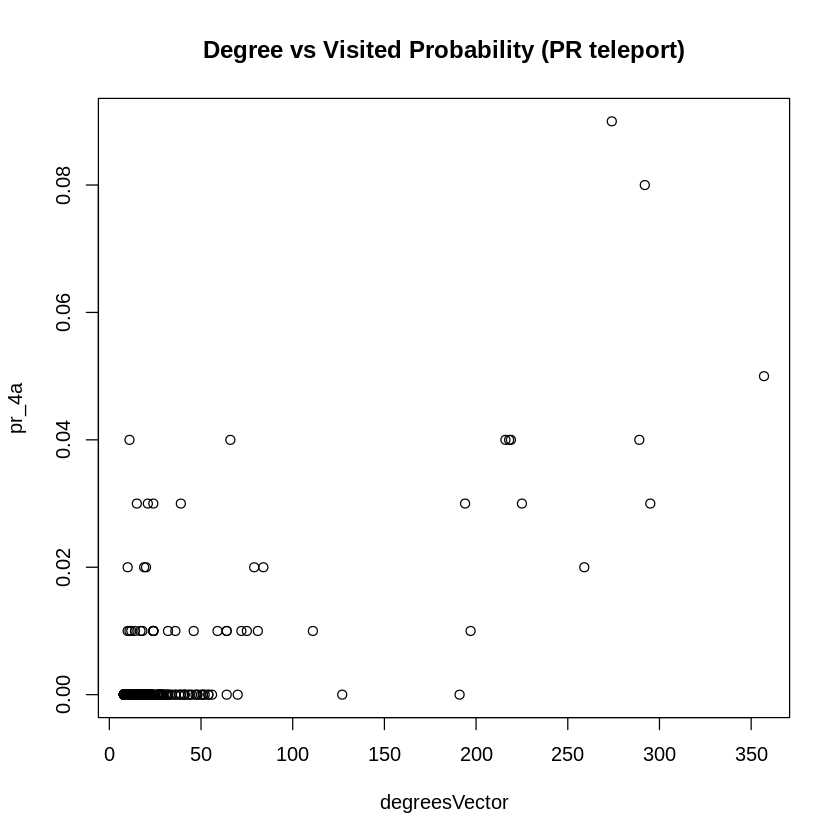

In [12]:
plot(pr_4a, xlab="Node Index", ylab="Visited probability", main= "Visited probability for each node (PR teleport)")

plot(degreesVector, pr_4a, main = "Degree vs Visited Probability (PR teleport)")

In [13]:
print(cor(degreesVector, pr_4a))

[1] 0.7655455


#### (b) Median PageRanks

In [27]:
sort_pagerank <- sort(pagerank_base, index.return=TRUE)
medians <- c(sort_pagerank$ix[N/2], sort_pagerank$ix[N/2 + 1])

num_steps <- 500
num_iters <- 100
mode_4b <- "prmedian"

pr_4b <- eval_page_rank(g=combined_graph,
                                    mode=mode_4b,
                                    num_iters=num_iters,
                                    num_steps=num_steps,
                                    pr=prmedian,
                                    medians=medians)

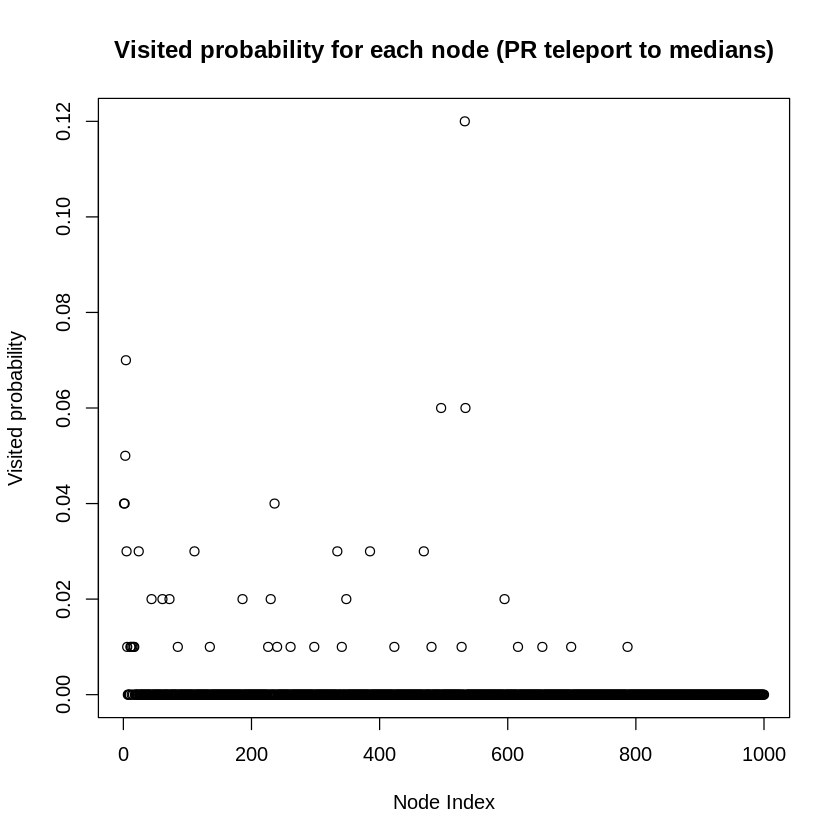

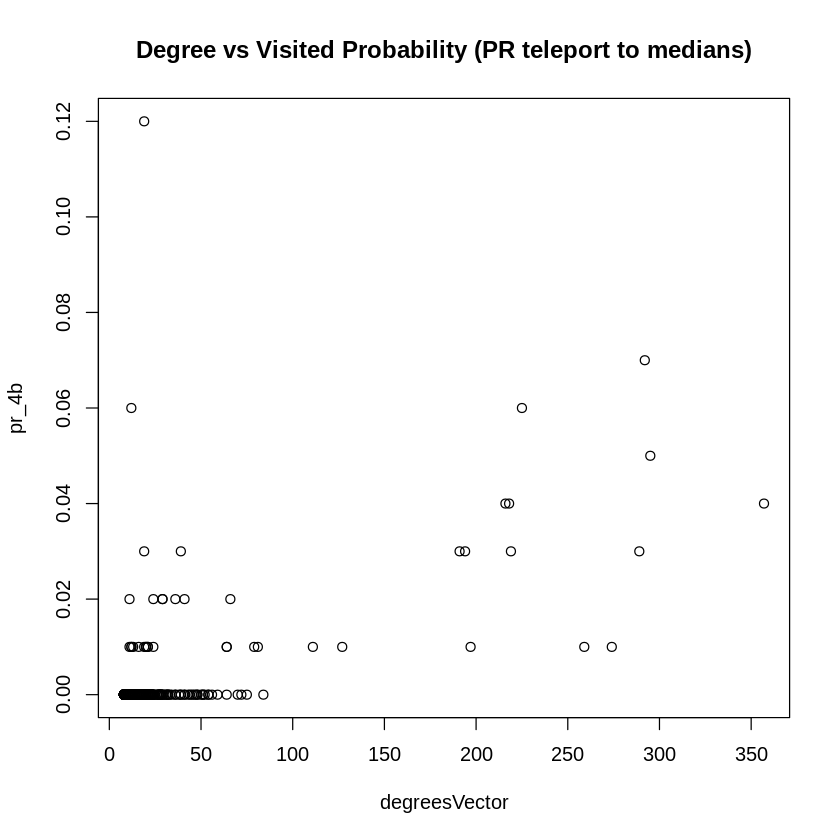

In [28]:
plot(pr_4b, xlab="Node Index", ylab="Visited probability", main= "Visited probability for each node (PR teleport to medians)")

plot(degreesVector, pr_4b, main = "Degree vs Visited Probability (PR teleport to medians)")

In [29]:
print(cor(degreesVector, pr_4b))

[1] 0.6020156
